# Model Output Analysis and Climate Change Impact Analysis

Now that we have run MATILDA so many times we finally want to have a look at the **results**. In this notebook we will...

1. ...create **custom data frames** containing individual output variables from all ensemble members,

2. ...**plot the ensemble mean** of these variables with a 90% confidence interval,

3. ...and create an **interactive application** to explore the results.

Further,to highlight the impacts of climate change on our catchment we can calculate a set of indicators frequently used in climate impact studies. We will ...

4. ...calculate **meterological and hydrological statistics** for our modelling results,

5. ...plot these climate change indcators **interactive applications** to explore the impacts.

## Custom dataframes

First, we read our paths from the `config.ini` again and use some helper functions to convert our stored MATILDA output back into a dictionary.

In [1]:
from tools.helpers import pickle_to_dict, parquet_to_dict,read_yaml
import os
import configparser

# read output directory from config.ini file
config = configparser.ConfigParser()
config.read('config.ini')
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
dir_input = config['FILE_SETTINGS']['DIR_INPUT']
settings = read_yaml(os.path.join(dir_output, 'settings.yml'))

# set the file format for storage
compact_files = config.getboolean('CONFIG','COMPACT_FILES')

print("Importing MATILDA scenarios...")

if compact_files:
    # For size:
    matilda_scenarios = parquet_to_dict(f"{dir_output}cmip6/adjusted/matilda_scenarios_parquet")
else:
    # For speed:
    matilda_scenarios = pickle_to_dict(f"{dir_output}cmip6/adjusted/matilda_scenarios.pickle")


Importing MATILDA scenarios...


At the moment, the structure of the ensemble output is as follows:

To analyze all projections of a single variable, we need a function to rearrange the data. The `custom_df_matilda()` function returns a dataframe with all ensemble members for a given variable and scenario resampled to a desired frequency, e.g. **the total annual runoff under SSP 2**.

In [2]:
from tools.plots import custom_df_matilda
import pandas as pd

# Application example:
print('Total Annual Runoff Projections across Ensemble Members:\n')
matilda_SSP2 = custom_df_matilda(matilda_scenarios, 'SSP2', 'total_runoff', 'YE')

print(matilda_SSP2.head())

Total Annual Runoff Projections across Ensemble Members:

            ACCESS-CM2  ACCESS-ESM1-5  BCC-CSM2-MR       CESM2  CESM2-WACCM  \
TIMESTAMP                                                                     
2000-12-31  757.291964     757.291964   757.291964  757.291964   757.291964   
2001-12-31  737.809157     737.809157   737.809157  737.809157   737.809157   
2002-12-31  729.707377     729.707377   729.707377  729.707377   729.707377   
2003-12-31  614.939181     614.939181   614.939181  614.939181   614.939181   
2004-12-31  676.424451     676.424451   676.424451  676.424451   676.424451   

            CMCC-CM2-SR5   CMCC-ESM2  CNRM-CM6-1  CNRM-ESM2-1     CanESM5  \
TIMESTAMP                                                                   
2000-12-31    757.291964  757.291964  757.291964   757.291964  757.291964   
2001-12-31    737.809157  737.809157  737.809157   737.809157  737.809157   
2002-12-31    729.707377  729.707377  729.707377   729.707377  729.707377   
200

## Plot ensemble mean with confidence interval

Showing 31 curves in one figure gets confusing. A standard way to visualize ensemble data is to plot **the mean** (or median) **across all ensemble members with a confidence interval**. We choose a 95% confidence interval, meaning that based on this sample of 31 climate models, there is a 95% probability that the "true" mean lies within this interval. For that we are using the `confidence_interval()` function.

[<img src="https://miro.medium.com/max/3840/1*qSCzTfliGMCcPfIQcGIAJw.jpeg" width="70%"/>](https://miro.medium.com/max/3840/1*qSCzTfliGMCcPfIQcGIAJw.jpeg)

&copy; *[Stefanie Owens @ Medium.com](https://medium.com/design-ibm/who-needs-backup-dancers-when-you-can-have-confidence-intervals-485f9464c06f)*

In [3]:
from tools.helpers import confidence_interval

confidence_interval = confidence_interval(matilda_SSP2)
print('\n95% Confidence Intervals for Total Annual Runoff Projections:\n')
print(confidence_interval)




95% Confidence Intervals for Total Annual Runoff Projections:

                  mean    ci_lower    ci_upper
TIMESTAMP                                     
2000-12-31  757.291964  757.291964  757.291964
2001-12-31  737.809157  737.809157  737.809157
2002-12-31  729.707377  729.707377  729.707377
2003-12-31  614.939181  614.939181  614.939181
2004-12-31  676.424451  676.424451  676.424451
...                ...         ...         ...
2096-12-31  576.415676  540.393256  612.438096
2097-12-31  586.491570  556.622346  616.360795
2098-12-31  603.062089  569.238526  636.885652
2099-12-31  584.642619  541.845857  627.439381
2100-12-31  618.261422  583.622165  652.900679

[101 rows x 3 columns]


We are going to use the `plotly` library again to create interactive plots. For now, let's plot *total discharge* over all ensemble members. You can change the variables and resampling frequency in the example at will.

In [4]:
from tools.plots import plot_ci_matilda

# Application example
plot_ci_matilda('total_runoff',dic=matilda_scenarios, resample_freq='YE', show=True)

## Interactive plotting application 

To make the full dataset more accessible, we can integrate these figures into an **interactive application** using [`ploty.Dash`](https://dash.plotly.com/). This launches a `Dash` server that updates the figures as you select variables and frequencies in the **dropdown menus**. To compare time series, you can align multiple figures in the same application. The demo application aligns three figures showing *total runoff, total precipitation* and *runoff_from_glaciers* by default directly in the output cell. If you want to display the complete application in a separate Jupyter tab, set `display_mode='tab'`.

In [5]:
from tools.helpers import adjust_jupyter_config

# retrieve server information to find out whether it's running locally or on mybinder.org server
adjust_jupyter_config()

IndexError: list index out of range

In [ ]:
from dash import Dash
from jupyter_server import serverapp
from tools.plots import matilda_dash

app1 = Dash(__name__)
matilda_dash(app1,dic=matilda_scenarios, fig_count=4, default_vars=[...], display_mode='inLine')

port = 8051
if list(serverapp.list_running_servers()) == []:
    app1.run(port=port, jupyter_mode="external")
else:
    app1.run(port=port)

Dash app running on http://127.0.0.1:8051/


## Climate Change Impact Analysis

This module calculates the following statistics for all ensemble members in annual resolution:

- Month with minimum/maximum precipitation
- Timing of Peak Runoff
- Begin, End, and Length of the melting season
- Potential and Actual Aridity
- Total Length of Dry Spells
- Average Length and Frequency of Low Flow Events
- Average Length and Frequency of High Flow Events
- 5th Percentile of Total Runoff
- 50th Percentile of Total Runoff
- 95th Percentile of Total Runoff
- Climatec Water Balance
- SPI (Standardized Precipitation Index) and SPEI (Standardized Precipitation Evapotranspiration Index) for 1, 3, 6, 12, and 24 months

For details on these metrics check the [source code](tools/indicators.py).

In [6]:
import pandas as pd
from tools.helpers import dict_to_pickle, dict_to_parquet, calculate_indicators

print("Calculating Climate Change Indicators...")
matilda_indicators = calculate_indicators(matilda_scenarios)
print("Writing Indicators To File...")

if compact_files:
    dict_to_parquet(matilda_indicators, f"{dir_output}cmip6/adjusted/matilda_indicators_parquet")
else:
    dict_to_pickle(matilda_indicators, f"{dir_output}cmip6/adjusted/matilda_indicators_pickle")

Calculating Climate Change Indicators...


SSP5: 100%|██████████| 31/31 [00:11<00:00,  2.79it/s]

Writing Indicators To File...


In [7]:
import shutil

# refresh `output_download.zip` with data retrieved within this notebook
shutil.make_archive('output_download', 'zip', 'output')
print('Output folder can be download now (file output_download.zip)')

Output folder can be download now (file output_download.zip)


Similar to the last notebook we write a function to **create customs dataframes for individual indicators** across all ensemble members and write a plot function for a single plot.


In [8]:
from tools.indicators import indicator_vars
from tools.plots import plot_ci_indicators
    

plot_ci_indicators(var = 'potential_aridity', dic = matilda_indicators, plot_type='line', show=True)

Then we are creating a creating again an <b>interactive application</b> to visualize the calculated indicators.

In [9]:
from tools.helpers import adjust_jupyter_config

 # retrieve server information to find out whether it's running locally or on mybinder.org server
adjust_jupyter_config()

IndexError: list index out of range

In [10]:
from tools.plots import matilda_indicators_dash
from dash import Dash
from jupyter_server import serverapp


app2 = Dash(__name__)
matilda_indicators_dash(app2, matilda_indicators)

port = 8051
if list(serverapp.list_running_servers()) == []:
    app2.run(port=port, jupyter_mode="external")
else:
    app2.run(port=port)

Dash app running on http://127.0.0.1:8051/


## Matilda Summary

Finally, we generate a <b>Meta Plot</b> to highlight the most important results in a single figure. 

total_runoff extracted for SSP2
total_runoff extracted for SSP5
actual_evaporation extracted for SSP2
actual_evaporation extracted for SSP5
total_precipitation extracted for SSP2
total_precipitation extracted for SSP5
glacier_area extracted for SSP2
glacier_area extracted for SSP5
snow_melt_on_glaciers extracted for SSP2
snow_melt_on_glaciers extracted for SSP5
ice_melt_on_glaciers extracted for SSP2
ice_melt_on_glaciers extracted for SSP5
melt_off_glaciers extracted for SSP2
melt_off_glaciers extracted for SSP5
Creating MATILDA summary plot...
Plotting glacierized area...
Plotting snow & ice melt...
Plotting runoff & precipitation...
Plotting temperature...


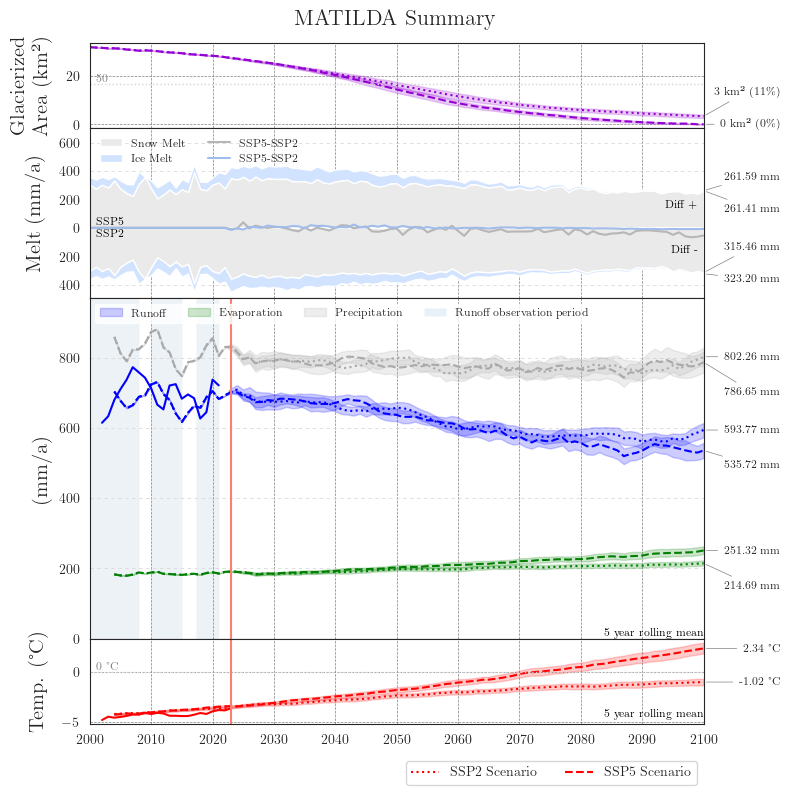

In [ ]:
from tools.plots import MetaPlot

metaplot = MetaPlot(dir_input, dir_output, settings)
metaplot.load_data()

metaplot.plot_summary(rolling=5, save_path=None);